여기는 csv 파일에 image_path와 캡션이 저장되어있으면 그걸 읽어서 쌍을 만들어 fashion clip을 파인튜닝학습시키고 저장하는 함수

In [ ]:
# FashionCLIP Fine-tuning (Hugging Face Transformers)

#This notebook fine-tunes `patrickjohncyh/fashion-clip` on your own image–text dataset using the CLIP contrastive objective.

#- Expected CSV format: `image_path,caption`
#- Images can be absolute paths or relative to `IMG_ROOT`.
#- Works on Google Colab (GPU recommended).


SyntaxError: invalid character '–' (U+2013) (ipython-input-1121901545.py, line 3)

In [ ]:
# Colab/Env setup
!pip -q install --upgrade pip
!pip -q install "transformers>=4.41" "datasets>=2.19" "torch>=2.1" torchvision pillow accelerate timm einops pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
import io
import random
from dataclasses import dataclass
from typing import Optional, List, Dict

import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

IMG_ROOT = os.environ.get("IMG_ROOT", ".")
CSV_PATH = os.environ.get("CSV_PATH", "/content/drive/MyDrive/graduateproject/data/pairs_image_text_unique.csv")

class CLIPCsvDataset(Dataset):
	def __init__(self, csv_path: str, img_root: str = "."):
		self.df = pd.read_csv(csv_path)
		if not {"image_path", "caption"}.issubset(set(self.df.columns)):
			raise ValueError("CSV must contain 'image_path' and 'caption' columns")
		self.img_root = img_root

	def __len__(self) -> int:
		return len(self.df)

	def __getitem__(self, idx: int) -> Dict[str, str]:
		row = self.df.iloc[idx]
		img_path = row["image_path"]
		if not os.path.isabs(img_path):
			img_path = os.path.join(self.img_root, img_path)
		image = Image.open(img_path).convert("RGB")
		return {"image": image, "text": str(row["caption"]) }

@dataclass
class DataCollatorCLIP:
	processor: any
	max_length: int = 77

	def __call__(self, batch: List[Dict[str, Image.Image]]):
		images = [b["image"] for b in batch]
		texts = [b["text"] for b in batch]
		enc = self.processor(text=texts, images=images, padding=True, truncation=True, max_length=self.max_length, return_tensors="pt")
		return enc

train_ds = CLIPCsvDataset(CSV_PATH, IMG_ROOT)
print(f"Loaded {len(train_ds)} rows from {CSV_PATH}")


Loaded 1620 rows from /content/drive/MyDrive/graduateproject/data/pairs_image_text_unique.csv


무엇을 하는 코드인가?
목적: CSV 파일에 있는 이미지 경로와 캡션을 읽어, CLIP 학습/파인튜닝에 바로 넣을 수 있는 형태로 준비합니다.
구성 설명
환경변수: IMG_ROOT(이미지 루트 경로), CSV_PATH(CSV 파일 경로). 기본값은 각각 ".", "data.csv"입니다.
CSV 형식: 반드시 image_path, caption 두 컬럼이 있어야 합니다.
CLIPCsvDataset (PyTorch Dataset)
__init__: CSV를 읽고 컬럼 유효성 검사, 이미지 루트 경로 저장.
__len__: 데이터 개수 반환.
__getitem__: 인덱스에 해당하는 행을 가져와
image_path가 상대경로면 IMG_ROOT와 합쳐 실제 경로로 만듭니다.
이미지를 PIL.Image.open(...).convert("RGB")로 열고
{"image": image, "text": caption} 딕셔너리를 반환합니다.
DataCollatorCLIP
Hugging Face의 CLIPProcessor를 받아서, 배치(list of dict)를
processor(text=texts, images=images, padding=True, truncation=True, max_length=77, return_tensors="pt")
형태로 토치 텐서 배치로 변환합니다. 즉, 토크나이징/리사이즈/정규화 등을 한 번에 처리합니다.
마지막 두 줄
train_ds = CLIPCsvDataset(CSV_PATH, IMG_ROOT): 데이터셋 생성
로드된 샘플 수를 출력
어떻게 쓰나요?
보통은 DataLoader와 함께 사용합니다.
예시:
이렇게 만든 loader의 배치를 그대로 CLIPModel에 model(**batch)로 넣어 학습/평가에 사용합니다.

In [31]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torch.utils.data import DataLoader

MODEL_ID = "patrickjohncyh/fashion-clip"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
model.to(device)

BATCH_SIZE = int(os.environ.get("BATCH_SIZE", 32))
NUM_WORKERS = int(os.environ.get("NUM_WORKERS", 2))

collator = DataCollatorCLIP(processor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collator)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

FashionCLIP 로드 및 배치 생성: 사전학습된 FashionCLIP을 가져오고, 앞서 만든 DataCollatorCLIP과 train_ds로 학습용 DataLoader를 구성합니다.
라인별 핵심
L1–L3: 필요한 모듈 임포트. Hugging Face CLIPProcessor, CLIPModel, PyTorch DataLoader.
L5: MODEL_ID를 FashionCLIP 체크포인트로 설정.
L6: CUDA 사용 가능 시 GPU, 아니면 CPU 선택.
L8–L10: 사전학습된 프로세서/모델 로드 후 장치로 이동.
CLIPProcessor: 텍스트 토크나이징, 이미지 리사이즈/정규화 등 전처리.
CLIPModel: CLIP의 텍스트/이미지 인코더와 대조 학습 로스 제공.
L12–L13: 배치 크기와 num_workers를 환경변수로부터 읽고 기본값 설정.
L15: DataCollatorCLIP(processor)로 배치 전처리기 준비. 배치의 {"image","text"} 리스트를 모델 입력 텐서로 변환.
L16: DataLoader 생성. train_ds를 섞어 읽고, collate_fn으로 프로세서 기반 전처리 적용.
결과 배치는 CLIP에 바로 넣을 수 있는 키(예: input_ids, attention_mask, pixel_values 등)를 포함합니다.

In [42]:
import math
from torch.optim import AdamW
from accelerate import Accelerator

EPOCHS = int(os.environ.get("EPOCHS", 3))
LR = float(os.environ.get("LR", 5e-6))
WEIGHT_DECAY = float(os.environ.get("WEIGHT_DECAY", 0.02))
GRAD_ACCUM = int(os.environ.get("GRAD_ACCUM", 1))

# Freeze vision/text encoders partially if desired
FREEZE_VIS = bool(int(os.environ.get("FREEZE_VIS", 0)))
FREEZE_TXT = bool(int(os.environ.get("FREEZE_TXT", 0)))

if FREEZE_VIS:
	for p in model.vision_model.parameters():
		p.requires_grad = False
if FREEZE_TXT:
	for p in model.text_model.parameters():
		p.requires_grad = False

# Optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)

accelerator = Accelerator(mixed_precision="fp16")
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

num_update_steps_per_epoch = math.ceil(len(train_loader) / GRAD_ACCUM)
t_total = EPOCHS * num_update_steps_per_epoch
print(f"Total steps: {t_total}")
print(len(train_ds))

model.train()
for epoch in range(EPOCHS):
	loss_sum = 0.0
	for step, batch in enumerate(train_loader):
		outputs = model(**{k: v.to(accelerator.device) for k, v in batch.items()})
		logits_i = outputs.logits_per_image
		logits_t = outputs.logits_per_text
		labels = torch.arange(logits_i.size(0), device=logits_i.device)
		loss_i = torch.nn.functional.cross_entropy(logits_i, labels)
		loss_t = torch.nn.functional.cross_entropy(logits_t, labels)
		loss = (loss_i + loss_t) / 2 / GRAD_ACCUM
		accelerator.backward(loss)
		if (step + 1) % GRAD_ACCUM == 0:
			optimizer.step()
			optimizer.zero_grad()
		loss_sum += loss.item()
		if (step + 1) % 50 == 0:
			accelerator.print(f"epoch {epoch+1} step {step+1} loss {loss_sum / (step+1):.4f}")
	accelerator.print(f"Epoch {epoch+1} | mean loss: {loss_sum / (step+1):.4f}")


Total steps: 153
1620
epoch 1 step 50 loss 3.0505
Epoch 1 | mean loss: 3.0387
epoch 2 step 50 loss 2.2707
Epoch 2 | mean loss: 2.2657
epoch 3 step 50 loss 1.4117
Epoch 3 | mean loss: 1.4159


목적: FashionCLIP을 FP16 혼합정밀 + Accelerate로 학습합니다. 선택적으로 비전/텍스트 인코더를 동결하고, AdamW와 그라디언트 누적을 사용합니다.
블록별 설명
하이퍼파라미터
EPOCHS, LR, WEIGHT_DECAY, GRAD_ACCUM: 에폭 수, 학습률, 가중치 감쇠, 그라디언트 누적 스텝 수를 환경변수에서 읽어옵니다.
누적 사용 시 loss / GRAD_ACCUM으로 나눠서 역전파하고, 매 GRAD_ACCUM 스텝마다 optimizer.step()을 합니다.
동결 옵션
FREEZE_VIS, FREEZE_TXT가 1이면 각각 model.vision_model, model.text_model의 파라미터를 고정(requires_grad=False)합니다.
분류기(프로젝션)만 업데이트하고 인코더는 고정하고 싶을 때 유용합니다.
옵티마이저
AdamW(filter(lambda p: p.requires_grad, model.parameters()), ...)로 학습 가능한 파라미터만 최적화합니다.
Accelerate 설정
Accelerator(mixed_precision="fp16"): 자동으로 FP16/FP32 혼합정밀과 디바이스 처리를 관리합니다.
model, optimizer, train_loader = accelerator.prepare(...): 모델/옵티마이저/데이터로더를 분산·혼합정밀에 맞게 래핑합니다.
스텝 수 계산
num_update_steps_per_epoch = ceil(len(train_loader) / GRAD_ACCUM):
누적 덕분에 실제 옵티마이저 업데이트 횟수를 반영합니다.
t_total = EPOCHS * num_update_steps_per_epoch: 총 업데이트 횟수 로그용.
학습 루프
model.train(): 학습 모드.
배치 처리:
batch.items()를 accelerator.device로 이동해 model(**...) 호출.
outputs.loss: CLIP 대조(contrastive) 로스. 이미지-텍스트 정합을 최대화하도록 학습됩니다.
loss = outputs.loss / GRAD_ACCUM 후 accelerator.backward(loss)로 역전파.
스텝이 GRAD_ACCUM 배수일 때 optimizer.step(); optimizer.zero_grad().
로깅: 50 스텝마다, 에폭 종료마다 평균 손실을 accelerator.print로 출력합니다(멀티프로세스에서 안전).
핵심 포인트
혼합정밀(FP16): 메모리 절약·속도 향상. accelerator.prepare가 자동 관리.
그라디언트 누적: 큰 유효 배치 사이즈를 구현. 손실을 나눠 누적 후 스텝 업데이트.
선택적 동결: 데이터가 적을 때 과적합/불안정 방지를 위해 인코더 고정 가능.
CLIP 로스: 이미지와 텍스트 임베딩 간 유사도를 기반으로 하는 대조 학습 손실을 자동 제공.

In [37]:
# Simple retrieval demo (optional)
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model.eval()

with torch.no_grad():
	batch = next(iter(train_loader))
	batch = {k: v.to(device) for k, v in batch.items()}
	outputs = model(**batch)
	image_embeds = outputs.image_embeds
	text_embeds = outputs.text_embeds
	image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
	text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
	sim = (image_embeds @ text_embeds.T).softmax(dim=1)
	print("Similarity (first 5 rows):\n", sim[:5].detach().cpu().numpy())


Similarity (first 5 rows):
 [[0.0317145  0.03121042 0.03146768 0.03152669 0.03093896 0.0316013
  0.0310579  0.03138563 0.03111646 0.03106451 0.03133938 0.03133938
  0.03104692 0.03134273 0.03133938 0.03111548 0.03133985 0.03124282
  0.03136738 0.03120209 0.03089355 0.03135738 0.03093514 0.03119704
  0.03102263 0.03134868 0.03151077 0.03153268 0.03095066 0.03125169
  0.03103879 0.0312015 ]
 [0.03100181 0.03111755 0.03134237 0.03114955 0.0308944  0.03106434
  0.03119679 0.03102845 0.03085395 0.03140327 0.03138497 0.03138497
  0.03118022 0.03124016 0.03138497 0.0314136  0.03114506 0.03115696
  0.03105614 0.03128849 0.03128369 0.03104644 0.03126063 0.03154233
  0.03152893 0.03137543 0.03117285 0.03127086 0.03159685 0.03159105
  0.03130836 0.03133458]
 [0.03132778 0.03131585 0.03149839 0.03125343 0.03137456 0.03105105
  0.03133768 0.03119207 0.03104684 0.03140128 0.03118599 0.03118599
  0.03112528 0.03118645 0.03118599 0.03112228 0.0313882  0.03089334
  0.03122362 0.03125207 0.03135002 0.03

01. /content/drive/MyDrive/graduateproject/data/cloth/빈티지/034_4987293_4987293_17443384376109_500.jpg | score=0.2674
02. /content/drive/MyDrive/graduateproject/data/cloth/레트로/035_4919066_4919066_17425359779326_500.jpg | score=0.2660
03. /content/drive/MyDrive/graduateproject/data/cloth/빈티지/007_5078944_5078944_17459163186151_500.jpg | score=0.2654
04. /content/drive/MyDrive/graduateproject/data/cloth/스트릿/021_5316660_5316660_17564590738724_500.png | score=0.2587
05. /content/drive/MyDrive/graduateproject/data/cloth/로맨틱/060_5074101_5074101_17539368258459_500.jpg | score=0.2573
06. /content/drive/MyDrive/graduateproject/data/cloth/스트릿/008_4231582_4231582_17200011237745_500.jpg | score=0.2516
07. /content/drive/MyDrive/graduateproject/data/cloth/스트릿/008_4231582_4231582_17200011237745_500.jpg | score=0.2516
08. /content/drive/MyDrive/graduateproject/data/cloth/펑크/044_4165125_4165125_17176527839476_500.jpg | score=0.2448
09. /content/drive/MyDrive/graduateproject/data/cloth/캐주얼/473_5097209_509

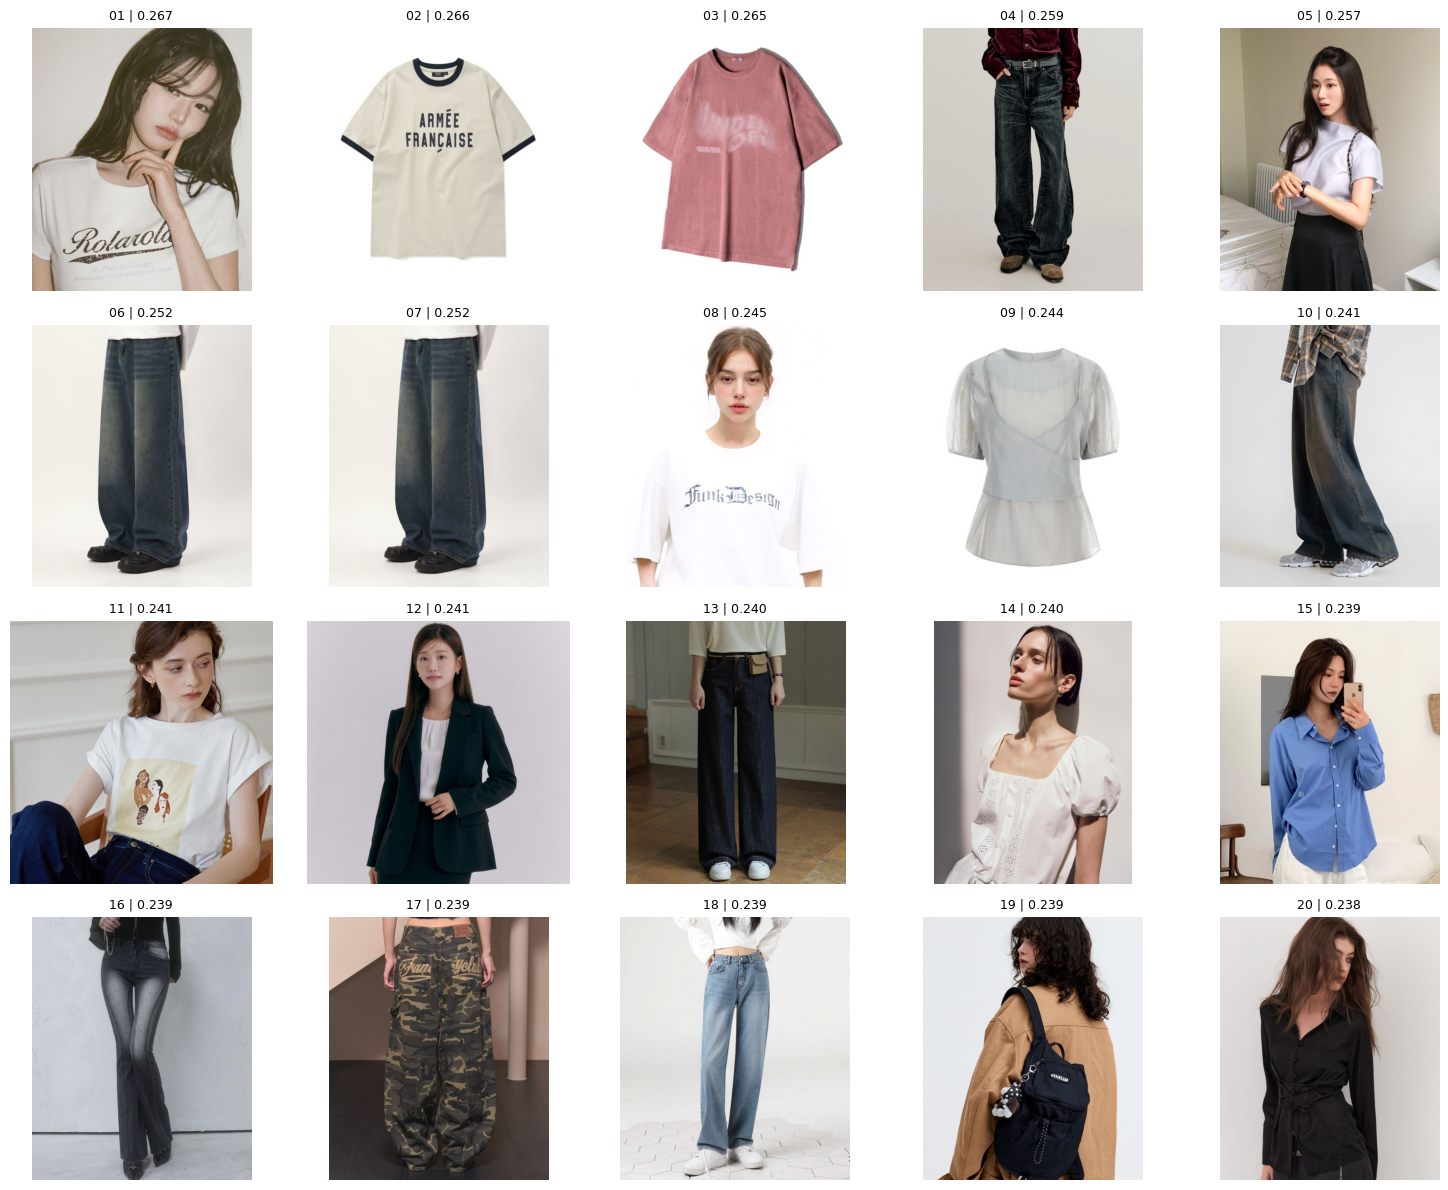

In [47]:
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
model.eval()

def encode_all_images(dataloader, model, device):
	embeds = []
	paths = []
	with torch.no_grad():
		for batch_items in dataloader:
			batch_items = {k: v.to(device) for k, v in batch_items.items()}
			outputs = model(**batch_items)
			img_emb = outputs.image_embeds
			img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
			embeds.append(img_emb.detach().cpu())
	# Collect image paths in the same order the dataloader serves
	# We rebuild by iterating the underlying dataset indices from the dataloader sampler if available
	if hasattr(dataloader, 'dataset') and hasattr(dataloader, 'sampler') and hasattr(dataloader.sampler, 'data_source'):
		# Fallback: assume the dataloader shuffles; we can't reconstruct exact order of paths here reliably
		# So we will directly pull paths by iterating dataset in order and then align by rebuilding a non-shuffled loader.
		pass
	embeds = torch.cat(embeds, dim=0)
	return embeds

# Build a NON-shuffled loader to keep alignment with dataset order for paths
from torch.utils.data import DataLoader
nonshuf_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collator)

# Cache to avoid recompute each time
_image_embeds_cache = None

def get_image_index_to_path(ds):
	# `CLIPCsvDataset.__getitem__` returns PIL image, so we cannot access paths there.
	# We reconstruct paths from the dataframe in order.
	if hasattr(ds, 'df') and 'image_path' in ds.df.columns:
		# Return absolute/relative as stored in the CSV (consistent with training loader processing)
		return ds.df['image_path'].tolist()
	raise ValueError("Dataset does not expose image paths via df['image_path'].")

def retrieve_top_k(caption, k=20):
	global _image_embeds_cache
	with torch.no_grad():
		if _image_embeds_cache is None:
			_image_embeds_cache = encode_all_images(nonshuf_loader, model, device)
		image_embeds = _image_embeds_cache  # (N, D)  <- 현재 CPU에 있음

		# 텍스트 인코딩 (텍스트 전용 처리)
		text_inputs = processor(text=[caption], return_tensors="pt", padding=True)
		text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
		text_features = model.get_text_features(**text_inputs)
		text_emb = text_features / text_features.norm(dim=-1, keepdim=True)  # (1, D)

		# 디바이스 정렬: 텍스트 임베딩을 이미지 임베딩과 동일 디바이스로
		text_emb = text_emb.to(image_embeds.device)

		# 코사인 유사도 top-k
		sim = (image_embeds @ text_emb.T).squeeze(1)  # (N,)
		topk = torch.topk(sim, k=min(k, sim.shape[0]), largest=True)
		top_indices = topk.indices.cpu().tolist()
		top_scores = topk.values.cpu().tolist()

		paths = get_image_index_to_path(train_ds)
		results = [(paths[i], float(top_scores[idx])) for idx, i in enumerate(top_indices)]
		return results
# EXAMPLE USAGE
user_caption = "indie band female, 얼어붙은 마음에 누가 입 맞춰줄까요? 봄을 기다린다는 말 그 말의 근거가 될 수 있나요"
top20 = retrieve_top_k(user_caption, k=20)
for i, (p, s) in enumerate(top20, 1):
	print(f"{i:02d}. {p} | score={s:.4f}")


def show_topk_images(results, img_root=IMG_ROOT, cols=5):
	paths, scores = zip(*results)
	resolved = [p if os.path.isabs(p) else os.path.join(img_root, p) for p in paths]
	n = len(resolved)
	rows = (n + cols - 1) // cols
	plt.figure(figsize=(3*cols, 3*rows))
	for i, (p, s) in enumerate(zip(resolved, scores), 1):
		ax = plt.subplot(rows, cols, i)
		ax.imshow(Image.open(p).convert("RGB"))
		ax.set_title(f"{i:02d} | {s:.3f}", fontsize=9)
		ax.axis("off")
	plt.tight_layout()
	plt.show()

# 결과 출력 후 이미지 표시
for i, (p, s) in enumerate(top20, 1):
	print(f"{i:02d}. {p} | score={s:.4f}")
show_topk_images(top20)

트 계산 안 함).
배치 준비
batch = next(iter(train_loader)): 한 배치만 샘플.
batch = {k: v.to(device) ...}: 텐서를 GPU/CPU 디바이스로 이동.
임베딩 추출
outputs = model(**batch): CLIP 전방향 수행.
outputs.image_embeds, outputs.text_embeds: 각각 이미지/텍스트 임베딩 텐서.
정규화(L2)
x = x / x.norm(dim=-1, keepdim=True): 각 임베딩을 단위 벡터로 만듦.
이렇게 하면 x @ y.T가 코사인 유사도와 동일해집니다.
유사도 및 확률
sim = (image_embeds @ text_embeds.T): 이미지-텍스트 유사도 행렬 (배치 크기 B면 B x B).
.softmax(dim=1): 각 이미지에 대해 텍스트들에 대한 확률 분포로 변환.
sim[:5] 출력: 상위 5개 행만 프린트. 대각선 값이 높을수록 매칭이 잘 된 것.

In [ ]:
# Save and reload
SAVE_DIR = os.environ.get("SAVE_DIR", "./fashionclip-ft")
os.makedirs(SAVE_DIR, exist_ok=True)

# Save processor and model
processor.save_pretrained(SAVE_DIR)
if accelerator.is_local_main_process:
	model.save_pretrained(SAVE_DIR)
print(f"Saved to {SAVE_DIR}")

# Reload for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reloaded = CLIPModel.from_pretrained(SAVE_DIR).to(device)
processor_reloaded = CLIPProcessor.from_pretrained(SAVE_DIR)

# Single-image inference example
from PIL import Image
img_path = os.environ.get("TEST_IMAGE", None)
if img_path:
	image = Image.open(img_path).convert("RGB")
	texts = ["a photo of a red shoe", "a photo of a black shoe"]
	inputs = processor_reloaded(text=texts, images=image, return_tensors="pt", padding=True).to(device)
	with torch.no_grad():
		out = model_reloaded(**inputs)
		probs = out.logits_per_image.softmax(dim=1)
		print("probs:", probs.cpu().numpy())

In [28]:
# Rebuild pairs guaranteeing up to 10 per song
# Strategy: try global no-replacement per style first; if a song is short, fill from any other style pools;
# if still short (all pools exhausted), fill with replacement as a last resort (logged).
import os
import csv
import random
import pandas as pd
from pathlib import Path

CLOTH_ROOT = "/content/drive/MyDrive/graduateproject/data/cloth"
SONGS_CSV = "/content/drive/MyDrive/graduateproject/data/songs_out_final.csv"
OUT_CSV_UNIQ = "/content/drive/MyDrive/graduateproject/data/pairs_image_text_unique.csv"

SAMPLE_PER_STYLE = {"first": 5, "second": 3, "third": 2}
TARGET_PER_SONG = 10
MAX_CAPTION_CHARS = 2000

STYLE_FOLDERS = {
	"나시": "나시",
	"나이키": "나이키",
	"레트로": "레트로",
	"로맨틱": "로맨틱",
	"미니멀": "미니멀",
	"비즈니스캐주얼": "비즈니스캐주얼",
	"빈티지": "빈티지",
	"섹시": "섹시",
	"스트릿": "스트릿",
	"스포티": "스포티",
	"시크": "시크",
	"언더아머": "언더아머",
	"오피스": "오피스",
	"캐주얼": "캐주얼",
	"클래식": "클래식",
	"펑크": "펑크",
}

VALID_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

# Load songs (contains styles and text fields)
songs_df = pd.read_csv(SONGS_CSV)

# Build per-style shuffled pools (no replacement across entire dataset)
style_to_pool = {}
random.seed(42)
all_images = []
for style_name in STYLE_FOLDERS.keys():
	folder_path = Path(CLOTH_ROOT) / STYLE_FOLDERS[style_name]
	if not folder_path.exists():
		style_to_pool[style_name] = []
		continue
	pool = [str(p) for p in folder_path.iterdir() if p.suffix.lower() in VALID_EXTS]
	random.shuffle(pool)
	style_to_pool[style_name] = pool
	all_images.extend(pool)

rows = []
num_songs = len(songs_df)
filled_with_replacement = 0
for _, row in songs_df.iterrows():
	styles = {
		"first": str(row.get("style_first", "")).strip(),
		"second": str(row.get("style_second", "")).strip(),
		"third": str(row.get("style_third", "")).strip(),
	}
	s_raw = row.get("summary", "")
	g_raw = row.get("genre_tags", "")
	m_raw = row.get("mood_tags", "")
	t_raw = row.get("texture_tags", "")
	summary = "" if pd.isna(s_raw) else str(s_raw).strip()
	genre_tag = "" if pd.isna(g_raw) else str(g_raw).strip()
	mood_tag = "" if pd.isna(m_raw) else str(m_raw).strip()
	texture_tag = "" if pd.isna(t_raw) else str(t_raw).strip()
	# Build caption prioritizing tags (genre, mood, texture) first, then summary fills leftover
	sep = ", "
	tags = [x for x in [genre_tag, mood_tag, texture_tag] if x]
	tags_str = sep.join(tags)
	if len(tags_str) > MAX_CAPTION_CHARS:
		caption = tags_str[:MAX_CAPTION_CHARS]
	else:
		caption = tags_str
		remain = MAX_CAPTION_CHARS - len(caption)
		if summary and remain > 0:
			# add separator only if tags existed and there is room
			prefix = (sep if caption else "")
			space_for_summary = remain - len(prefix)
			if space_for_summary > 0:
				caption = caption + prefix + summary[:space_for_summary]

	selected_for_song = []
	selected_set = set()
	# 1) take from declared styles without replacement
	for rank in ["first", "second", "third"]:
		style_name = styles[rank]
		if not style_name:
			continue
		pool = style_to_pool.get(style_name, [])
		if not pool:
			continue
		take_n = min(SAMPLE_PER_STYLE[rank], len(pool))
		for _ in range(take_n):
			img = pool.pop()
			if img in selected_set:
				continue
			selected_for_song.append(img)
			selected_set.add(img)

	# 2) top-up from any other style pools (still no-replacement globally)
	while len(selected_for_song) < TARGET_PER_SONG:
		# find a pool that still has images
		candidates = [k for k, v in style_to_pool.items() if len(v) > 0]
		if not candidates:
			break
		pick_style = random.choice(candidates)
		img = style_to_pool[pick_style].pop()
		if img in selected_set:
			continue
		selected_for_song.append(img)
		selected_set.add(img)

	# 3) last resort: allow replacement if we still don't have enough
	if len(selected_for_song) < TARGET_PER_SONG and all_images:
		need = TARGET_PER_SONG - len(selected_for_song)
		for _ in range(need):
			img = random.choice(all_images)
			# avoid duplicates within the song
			tries = 0
			while img in selected_set and tries < 10:
				img = random.choice(all_images)
				tries += 1
			selected_for_song.append(img)
			selected_set.add(img)
		filled_with_replacement += need

	for img_path in selected_for_song:
		rows.append({"image_path": img_path, "caption": caption})

os.makedirs(os.path.dirname(OUT_CSV_UNIQ), exist_ok=True)
with open(OUT_CSV_UNIQ, "w", newline="", encoding="utf-8") as f:
	writer = csv.DictWriter(f, fieldnames=["image_path", "caption"])
	writer.writeheader()
	writer.writerows(rows)

expected_total = num_songs * TARGET_PER_SONG
print(f"Expected rows: {expected_total} | Wrote: {len(rows)} | Filled with replacement: {filled_with_replacement}")
# Show remaining pool sizes for sanity
leftover = {k: len(v) for k, v in style_to_pool.items()}
print({k: leftover[k] for k in sorted(leftover)})


Expected rows: 1620 | Wrote: 1620 | Filled with replacement: 56
{'나시': 0, '나이키': 0, '레트로': 0, '로맨틱': 0, '미니멀': 0, '비즈니스캐주얼': 0, '빈티지': 0, '섹시': 0, '스트릿': 0, '스포티': 0, '시크': 0, '언더아머': 0, '오피스': 0, '캐주얼': 0, '클래식': 0, '펑크': 0}


In [ ]:
%%capture
!mkdir images/
!wget https://cdn-images.farfetch-contents.com/19/76/05/56/19760556_44221665_1000.jpg -O images/image1.jpg
!wget https://cdn-images.farfetch-contents.com/19/12/31/09/19123109_41833754_1000.jpg -O images/image2.jpg
!wget https://cdn-images.farfetch-contents.com/19/17/15/27/19171527_43252790_1000.jpg -O images/image3.jpg

In [ ]:
%%capture
!git clone https://github.com/patrickjohncyh/fashion-clip
!pip install -r fashion-clip/requirements.txt

In [ ]:
import os
import sys
sys.path.append("fashion-clip")
from fashion_clip.fashion_clip import FashionCLIP, FCLIPDataset
from fashion_clip.utils import get_cache_directory, display_images
print("Cache is at {}".format(get_cache_directory()))

Cache is at /root/.cache/fashion_clip


In [ ]:
catalog = [
    {'id': 1, 'image': 'image1.jpg', 'caption': 'we do not need this now'},
    {'id': 2, 'image': 'image2.jpg', 'caption': 'we do not need this now'},
    {'id': 3, 'image': 'image3.jpg', 'caption': 'we do not need this now'},
]
dataset = FCLIPDataset('farfetch_local',
                       image_source_path='./images',
                       image_source_type='local',
                       catalog=catalog)

In [ ]:
fclip = FashionCLIP('fashion-clip', dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

1it [00:01,  1.05s/it]


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

1it [00:00,  8.57it/s]

Normalizing Input Vectors...Done!
Building Approx NN index...Done!


In [ ]:
test_captions = [
    "black shoes", "red shoes", "nike blue sneakers", "a shirt", "nike",
    "library", "the flag of italy", "pizza", "a gucci dress"
]

Parameter 'function'=<function FashionCLIP.encode_text.<locals>.<lambda> at 0x7bee941313a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

2it [00:00, 30.14it/s]               
1it [00:00, 17.66it/s]


['black shoes']

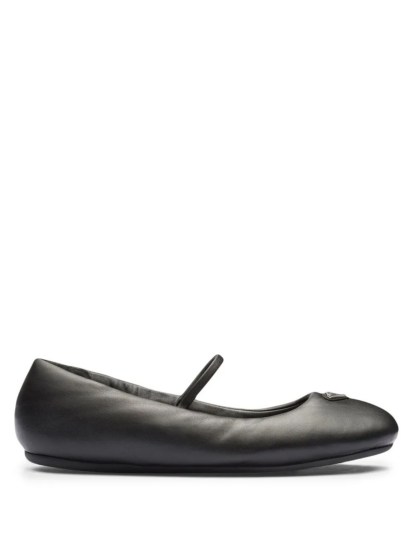

In [ ]:
test_img_path = 'images/image1.jpg'
display_images([test_img_path])
fclip.zero_shot_classification([test_img_path], test_captions)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

2it [00:00, 41.98it/s]               
1it [00:00, 23.44it/s]


['red shoes']

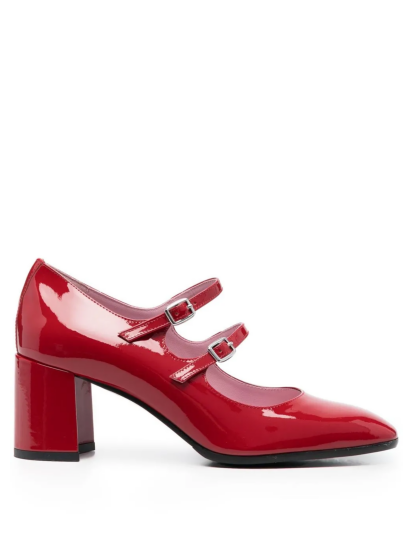

In [ ]:
test_img_path = 'images/image2.jpg'
display_images([test_img_path])
fclip.zero_shot_classification([test_img_path], test_captions)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

2it [00:00, 42.96it/s]               
1it [00:00, 16.64it/s]


['a shirt']

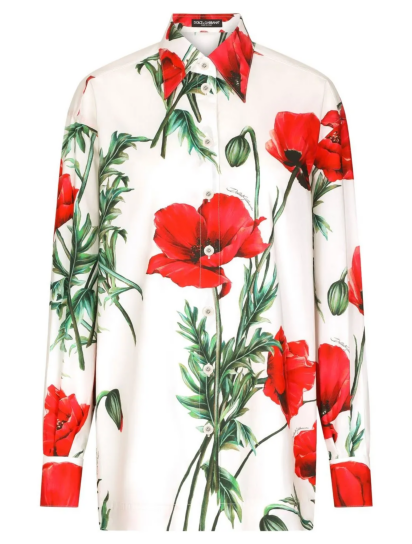

In [ ]:
test_img_path = 'images/image3.jpg'
display_images([test_img_path])
fclip.zero_shot_classification([test_img_path], test_captions)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 51.05it/s]


[[1, 0, 2]]


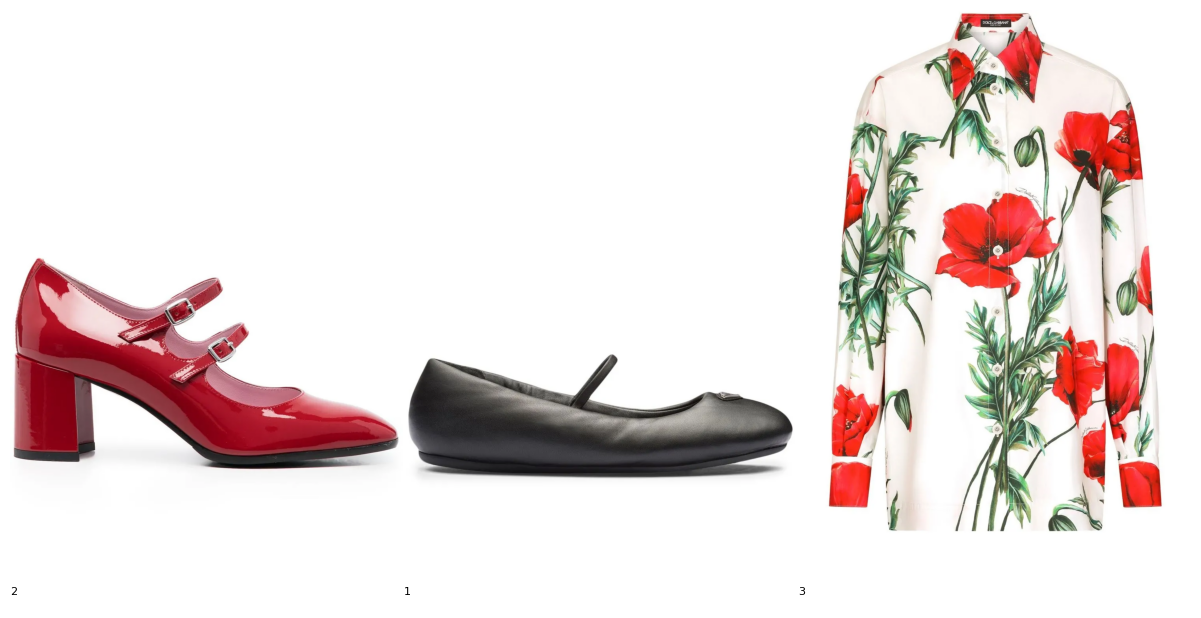

In [ ]:
candidates = fclip.retrieval(['a red shoe'])
print(candidates)
_ = dataset.display_products(dataset.ids[candidates[0]], fields=tuple(['id']))

tensor([[5.1756e-05, 9.9995e-01]], grad_fn=<SoftmaxBackward0>)


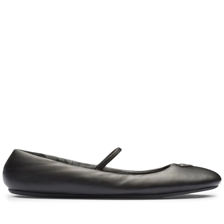

In [ ]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")

image = Image.open("images/image1.jpg")

inputs = processor(text=["a photo of a red shoe", "a photo of a black shoe"],
                   images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)
print(probs)
image.resize((224, 224))